1 Optimization
1.1 Preparing model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

In [2]:
from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers

In [3]:
np.random.seed(0)

In [4]:
'''
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data>=threshold)/data.shape[0]
    else:
        return np.sum(data<=threshold)/data.shape[0]

SMALLER = 'SMALLER'

def costs(data):
    return data[0]/1e9 # makes numbers nicer

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.001) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 80e6) #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN
Total_Investment_Costs = costs #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN
'''

"\ndef robustness(direction, threshold, data):\n    if direction == SMALLER:\n        return np.sum(data>=threshold)/data.shape[0]\n    else:\n        return np.sum(data<=threshold)/data.shape[0]\n\nSMALLER = 'SMALLER'\n\ndef costs(data):\n    return data[0]/1e9 # makes numbers nicer\n\nExpected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.001) #not ok\nExpected_Annual_Damage = functools.partial(robustness, SMALLER, 80e6) #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN\nTotal_Investment_Costs = costs #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN\n"

In [5]:
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data<=threshold)/data.shape[0]

SMALLER = 'SMALLER'

def costs(data):
    return data[0]/1e9 # makes numbers nicer

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.001) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 80e6) #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN
Total_Investment_Costs = costs #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN

In [6]:
from problem_formulation import get_model_for_problem_formulation

model, _ = get_model_for_problem_formulation(1)

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [8]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [9]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 10
    with MultiprocessingEvaluator(model, n_processes=3) as evaluator:
        results = evaluator.perform_experiments(scenarios=200,
                                                policies=4,
                                                uncertainty_sampling=Samplers.MC)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

KeyError: 'A.1 Total Costs'

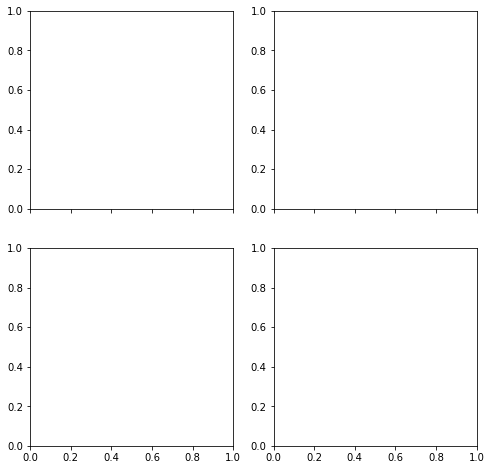

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs}

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

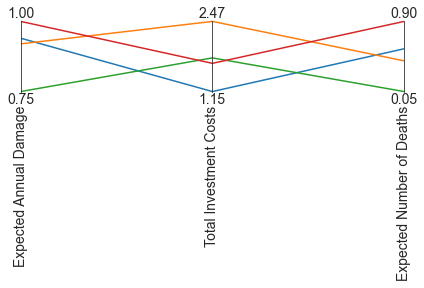

In [ ]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy

    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}

    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

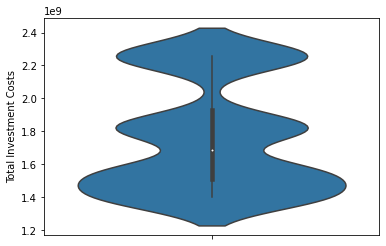

In [ ]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Total Investment Costs')
plt.show()

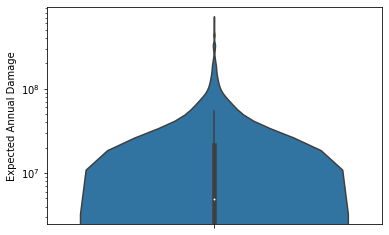

In [ ]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Annual Damage')
ax.set_yscale('log')
plt.show()

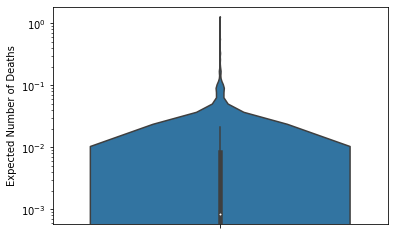

In [ ]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

In [14]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress

In [15]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = int(20000)  # Original value: 1000

In [ ]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                                     function=Expected_Number_of_Deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Total Investment Costs', kind=MAXIMIZE,
                                     function=Total_Investment_Costs),
                      ]
use_pickle4 = True
if use_pickle4:
    with open('data/moro_results4.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)
else:
    # we have to change the plausible max for total investment costs
    convergence = [HyperVolume(minimum=[0, 0, 0], maximum=[1.01, 1.01, 3.01]),
    EpsilonProgress(),]

    epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
    with MultiprocessingEvaluator(model) as evaluator:
        results4 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                         convergence=convergence, epsilons=epsilons)
    # Save results in Pickle file
    with open("data/moro_results4.pickle","wb") as filehandler:
        pickle.dump(results4, filehandler)
archive1, convergence = results4

[MainProcess/INFO] pool started with 8 workers
1095it [47:45,  2.62s/it]                                                      
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


c:\Users\roosd\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(


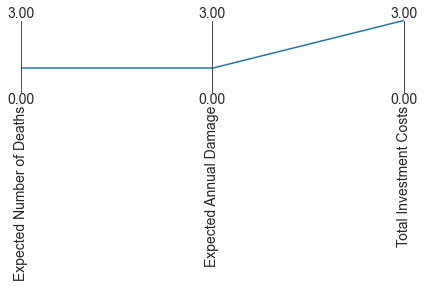

In [ ]:
from ema_workbench.analysis import parcoords

data = archive1.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 3

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

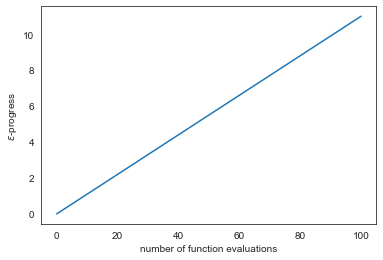

In [ ]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

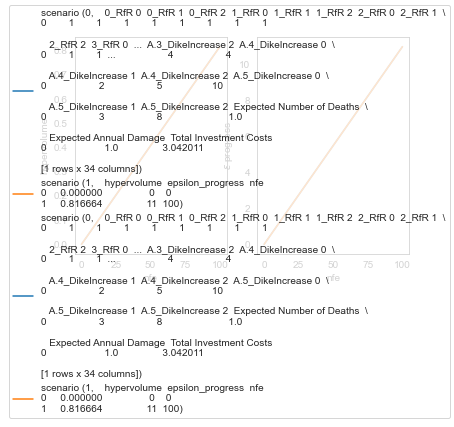

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
for i in enumerate(results4):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

In [ ]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                                     function=Expected_Number_of_Deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Total Investment Costs', kind=MAXIMIZE,
                                     function=Total_Investment_Costs),
                      ]
use_pickle5 = True
if use_pickle5:
    with open('data/moro_results10.pickle', 'rb') as filehandler:
        results5 = pickle.load(filehandler)
else:
    # we have to change the plausible max for total investment costs
    convergence = [HyperVolume(minimum=[0, 0, 0], maximum=[1.1, 1e9, 2.5e9]),
    EpsilonProgress(),]

    epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
    with MultiprocessingEvaluator(model) as evaluator:
        results5 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                         convergence=convergence, epsilons=epsilons)
    # Save results in Pickle file
    with open("data/moro_results10.pickle","wb") as filehandler:
        pickle.dump(results5, filehandler)
archive, convergence = results5

[MainProcess/INFO] pool started with 12 workers
1092it [18:12,  1.00s/it]                                                      
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


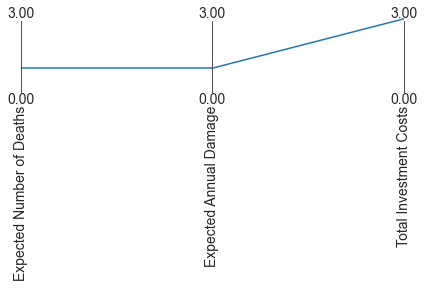

In [ ]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 3

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [16]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                                     function=Expected_Number_of_Deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Total Investment Costs', kind=MAXIMIZE,
                                     function=Total_Investment_Costs),
                      ]
use_pickle6 = True
if use_pickle6:
    with open('data/moro_results7.pickle', 'rb') as filehandler:
        results6 = pickle.load(filehandler)
else:
    # we have to change the plausible max for total investment costs
    convergence = [EpsilonProgress(),]

    epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
    with MultiprocessingEvaluator(model) as evaluator:
        results6 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                         convergence=convergence, epsilons=epsilons)
    # Save results in Pickle file
    with open("data/moro_results6.pickle","wb") as filehandler:
        pickle.dump(results6, filehandler)
archive6, convergence = results6

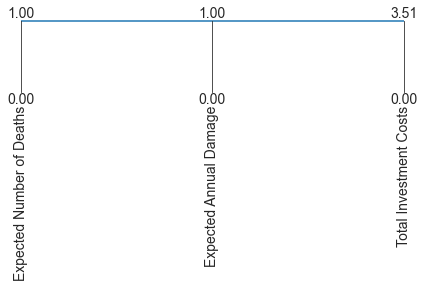

In [20]:
from ema_workbench.analysis import parcoords

data = archive6.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
# limits.loc[1, :] = 3

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Number of Deaths,Expected Annual Damage,Total Investment Costs
0,1,1,1,1,1,1,1,1,1,1,...,10,10,10,10,10,10,10,1.0,1.0,3.514305


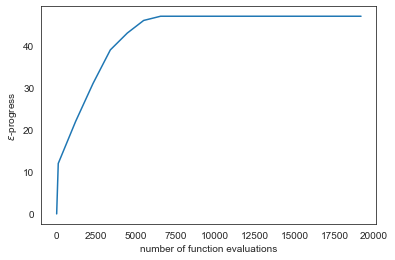

In [23]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()